In [25]:
!pip install navec

In [27]:
!pip install slovnet

     ---------------------------------------- 0.0/46.7 kB ? eta -:--:--
     ----------------------------------- ---- 41.0/46.7 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 46.7/46.7 kB 774.9 kB/s eta 0:00:00


In [33]:
!pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=31eeb8f14718beb5762706a78874ef1ce304c513c8410a14266f19193ef81b9f
  Stored in directory: c:\users\1\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [37]:
!python -m wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar


Saved under navec_hudlit_v1_12B_500K_300d_100q (1).tar


In [1]:
import os
import re
import math
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

from navec import Navec
from slovnet.model.emb import NavecEmbedding

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path) #download navec dictionaries
emb = NavecEmbedding(navec) #get navec embeddings

C:\Users\1\.conda\envs\cude_env\lib\site-packages\slovnet\model\emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  torch.from_numpy(navec.pq.indexes),


In [3]:
UNK_TOKEN_NUMBER = navec.vocab['<unk>']
PAD_TOKEN_NUMBER = navec.vocab['<pad>']
VOCAB_SIZE = len(navec.vocab.counts)
myVocabNumToWord = {} #dict to be able to get a word by number quickly

for i in range(len(navec.vocab.counts)):
    myVocabNumToWord[i] = navec.vocab.words[i]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {device} node')

using cuda node


In [5]:
class QuotesGenerator(nn.Module):

    def __init__(self, emb_dim, hid_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.output_dim = output_dim        
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)

        self.out = nn.Linear(hid_dim, output_dim)

        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, trg, batch_size, teacher_forcing_ratio=0.5, mode='train'):
        trg_len = len(trg[0]) #sentence length in the batch
        trg_vocab_size = self.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len-1, batch_size, trg_vocab_size).to(device)

        #make an initial input as first words of sentences
        input = [s[0] for s in trg]

        ids = [navec.vocab.get(word, UNK_TOKEN_NUMBER) for word in input]

        input = emb(torch.tensor(ids)).to(device)

        #initialize hidden and cell with zeros
        hidden = torch.zeros(self.n_layers, batch_size, self.hid_dim).to(device) 
        cell = torch.zeros(self.n_layers, batch_size, self.hid_dim).to(device)
        
        if mode != 'test':
            for t in range(0, trg_len-1):
    
                #add an axis to set that each word is a separate sequence with length 1
                input = input[None,:,:]
    
                output, (hidden, cell) = self.rnn(input, (hidden, cell))
                prediction = self.softmax(self.out(output.squeeze()))
                
                #place predictions in a tensor holding predictions for each token
                outputs[t] = prediction
    
                #get the highest predicted token from our predictions    
                top1 = prediction.argmax(-1)
    
                if mode == 'train':
                    #decide if we are going to use teacher forcing or not
                    teacher_force = random.random() < teacher_forcing_ratio
    
                    #if teacher forcing, use actual next token as next input
                    #if not, use predicted token
                    if teacher_force:
                        input = [s[t+1] for s in trg]
                        input = torch.tensor([navec.vocab.get(word, UNK_TOKEN_NUMBER) for word in input])
                    else:
                        input = torch.tensor([navec.vocab.get(myVocabNumToWord[i.item()]) for i in top1])
                #if we validate or test our model, no teacher forcing is applied        
                elif mode == 'valid':
                    input = torch.tensor([navec.vocab.get(myVocabNumToWord[i.item()]) for i in top1])
                    
                input = emb(input).to(device)
        else:
            outputs = []
            while True:
                #add an axis to set that each word is a separate sequence with length 1
                input = input[None,:,:]
    
                output, (hidden, cell) = self.rnn(input, (hidden, cell))
                prediction = self.softmax(self.out(output.squeeze()))

                #get the highest predicted token from our predictions and if it is unkown word
                #get the second highest predicted token
                if prediction.argmax(-1) == UNK_TOKEN_NUMBER:
                    prediction[UNK_TOKEN_NUMBER] = 0
                top1 = prediction.argmax(-1).detach()
                
                #place predictions in a tensor holding predictions for each token
                outputs.append(top1)

                #when padding token is generated, stop generation
                if top1 == PAD_TOKEN_NUMBER:
                    break
                        
                input = torch.tensor(navec.vocab.get(myVocabNumToWord[top1.item()])).view(1)                
                input = emb(input).to(device)

        return outputs

In [6]:
def read_batches(dataset):
    batch_number = len(dataset) // BATCH_SIZE

    for start in range(0, batch_number):
        batch = dataset[start*BATCH_SIZE: (start+1)*BATCH_SIZE]
        max_sentance_length = len(batch[-1])
        X = []
        for i in range(0, BATCH_SIZE):
            #if length of sentences in a batch is uneven, all sentence will have the same length
            #<pad>s are added to the end of shorter sentences
            #At the end of each word sequence an additional <pad> is added to imitate <eos>
            X.append(batch[i] + ['<pad>']*(max_sentance_length - len(batch[i])+1))

        yield X

In [7]:
def train(model, train_data, optimizer, criterion, clip, train_history, valid_history):
    
    model.train()    
    epoch_loss = 0
    history = []

    for i, X in enumerate(read_batches(train_data)):
        optimizer.zero_grad()

        output = model(X, batch_size=BATCH_SIZE)

        #get target word indexes
        idx = torch.tensor([[navec.vocab.get(word, UNK_TOKEN_NUMBER) for word in s] for s in [i[1:] for i in X]])

        #make a matrix of one-hot-vectors from target indexes
        trg = torch.tensor(np.zeros((idx.shape[1], idx.shape[0], VOCAB_SIZE)))
        for j in range(idx.shape[0]):
            trg[np.arange(idx.shape[1]), j, idx[j]] = 1

        loss = criterion(output.float().cpu(), trg.float().cpu())
        loss.backward()
        
        # Clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
    return epoch_loss / len(train_data)

In [8]:
def evaluate(model, valid_data, criterion):
    
    model.eval()    
    epoch_loss = 0    
    history = []
    
    with torch.no_grad():    
        for i, X in enumerate(read_batches(valid_data)):
            
            output = model(X, batch_size=BATCH_SIZE, mode='valid')

            #get target word indexes
            idx = torch.tensor([[navec.vocab.get(word, UNK_TOKEN_NUMBER) for word in s] for s in [i[1:] for i in X]])
            
            #make a matrix of one-hot-vectors from target indexes
            trg = torch.tensor(np.zeros((idx.shape[1], idx.shape[0], VOCAB_SIZE)))        
            for j in range(idx.shape[0]):
                trg[np.arange(idx.shape[1]), j, idx[j]] = 1
            
            loss = criterion(output.float().cpu(), trg.float().cpu())
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(valid_data)

In [9]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [10]:
def processData(text):
    train_text = [re.sub(r'[^\w\s]', ' ', s) for s in text.split('^')]
    train_text = [t.replace('\n',' ') for t in train_text]
    train_text = [sentence.lower() for sentence in train_text]
    train_text = [sentence.split()[:-1] for sentence in train_text]
    
    train_data, valid_data = train_test_split(train_text, test_size=0.3, random_state=1)
    valid_data, test_data = train_test_split(valid_data, test_size=0.5, random_state=1)
    
    train_data.sort(key=lambda x: len(x))
    valid_data.sort(key=lambda x: len(x))
    test_data.sort(key=lambda x: len(x))
    
    return train_data, valid_data, test_data

In [11]:
model = QuotesGenerator(emb_dim=300, 
                        hid_dim=512, 
                        output_dim=len(navec.vocab.counts), 
                        n_layers=2, 
                        dropout=0.3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
criterion = nn.BCELoss()

In [12]:
train_file = 'train_quotes.txt'

with open(train_file, 'r', encoding='utf-8') as data_file:
    text = data_file.read()
    
train_data, valid_data, test_data = processData(text)

train_data = train_data[2:1000] #get as much sentences as your computer can handle :), max 70363
valid_data = valid_data[3:250] #..., max 15078
test_data = test_data[3:250] #..., max 15078

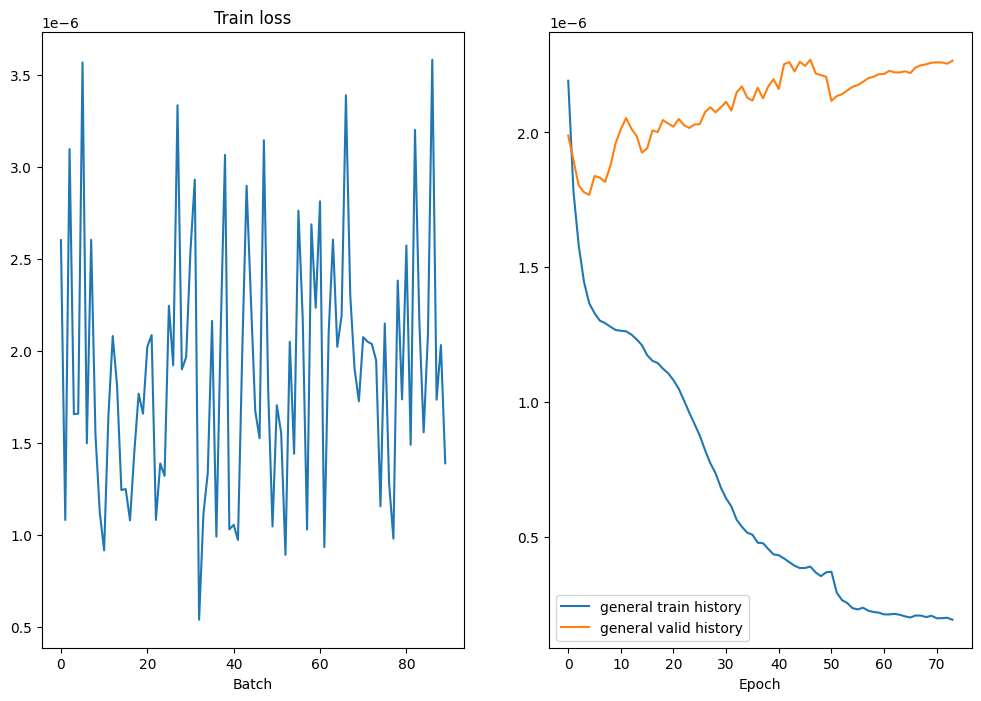

Epoch: 75 | Time: 0m 43s
	Train Loss: 0.192e-6
	 Val. Loss: 2.263e-6


In [13]:
N_EPOCHS = 75
BATCH_SIZE = 10
GRAD_CLIP = 0.1

train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    if epoch == 50:
        scheduler.step()
    
    train_loss = train(model, train_data, optimizer, criterion, GRAD_CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_data, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if epoch > 30 and valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pth')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    train_loss = train_loss*(10**((len(str(len(train_data))))+3))
    valid_loss = valid_loss*(10**((len(str(len(train_data)))+3)))
    print(f'\tTrain Loss: {train_loss:.3f}e-{len(str(len(train_data)))+3}')
    print(f'\t Val. Loss: {valid_loss:.3f}e-{len(str(len(train_data)))+3}')
    
# model.load_state_dict(torch.load('best-val-model.pth'))

In [14]:
test_loss = evaluate(model, test_data, criterion)
test_loss = test_loss*(10**((len(str(len(train_data))))+3))
print(f'\t Test Loss: {test_loss:.3f}e-{len(str(len(train_data)))+3}')

	 Test Loss: 2.191e-6


In [15]:
def generateSentence(word):
    ar = list([[word]])
    output = model(ar, batch_size=1, mode='test')
    sentence = [word]
    sentence += [myVocabNumToWord[i.item()] for i in output[:-1]]
    sentence[0] = sentence[0].capitalize()
    sentence = ' '.join(sentence) + '.'
    return sentence

In [31]:
generateSentence('девушки')

'Девушки становятся красивее когда влюбляются.'